## 손실 곡선
fit() 메서드 모델을 훈련하면 마지막 줄에 메시지가 따로 뜬다. 이 메시지는 fit() 메서드의 실행 결과를 출력한 것이다. fit()메서드가 무엇인가를 반환한다는 것. 이는 History 객체를 반환하는데 이 객체에는 훈련 과정에서 계산한 지표, 손실과 정확도가 저장되어있다. 이 값을 통해 그래프를 그릴 수 있다.

In [1]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
(train_input, train_target), (test_input, test_target) =\
    keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(
    train_scaled, train_target, test_size = 0.2, random_state=42
)

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28,28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    if a_layer:
        model.add(a_layer)
    model.add(keras.layers.Dense(10,activation='softmax'))
    return model

if구문은 model_fn() 함수에 케라스 층을 추가하면 은닉층 뒤에 또 하나의 층을 추가하는 것이다.

여기서 a_layer 매개변수로 층을 추가하지 않고 단순하게 model_fn() 함수를 호출한다. 그리고 모델 구조를 출력하면 이전 절과 동일한 모델이라는 것을 알 수 있다.

In [4]:
model = model_fn()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


그 다음 fit() 메서드의 결과를 history 변수에 담아보자.

In [5]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history=model.fit(train_scaled, train_target, epochs=5, verbose=0)

여기서 verbose=0 매개변수는 훈련 과정 출력을 조정하는 매개변수이다. 기본 값은 1으로 에포크마다 진행 막대와 손실 지표가 출력된다. 2로 바꾸면 진행 막대가 빼고 출력된다.

In [6]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


히스토리 딕셔너리에는 손실과 정확도가 들어있는 것을 볼 수 있다. 케라스는 기본적으로 에포크마다 손실을 계산한다. 정확도는 compile() 메서드에서 metrics 매개변수에 'accuracy'를 추가했기 때문에 history 속성에 포함된다.

history 속성에 포함된 손실과 정확도는 에포크마다 계산한 값이 순서대로 나열된 리스트이므로 맷플롯립을 사용하여 그래프로 그릴 수 있다.

In [5]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

NameError: ignored

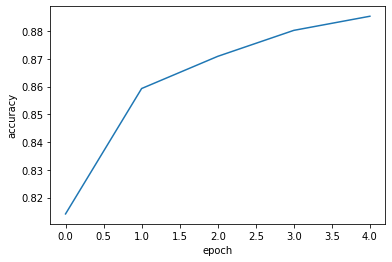

In [8]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

이번엔 에포크 횟수를 늘려 표현해보자.

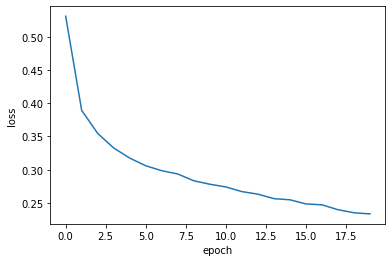

In [9]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

예상대로 손실이 감소하는게 보이지만 더 나은 모델을 훈련한 것인지 검증해야한다.

## 검증 손실
4장에서 확률적 경사 하강법을 사용했을 때 과대/과소적합과 에포크 사이의 관계를 알아보았다. 인공 신경망은 모두 일종의 경사 하강법을 사용하기 때문에 동일한 개념이 여기에도 적용이된다.

에포크에 따른 과대적합과 과소적합을 파악하려면 훈련 세트에 대한 점수뿐만 아니라 검증 세트에 대한 점수도 필요하다. 따라서 앞에서처럼 훈련 세트의 손실만 그려서는 안된다.

### 손실을 사용하는 것과 정확도를 사용하는 것의 차이
인공 신경망 모델이 최적화하는 대상은 손실 함수이다. 손실 감소에 비례하여 정확도가 높아지지 않는 경우도 있다. 따라서 모델이 잘 훈련되었는지 판단하려면 정확도보다는 손실 함수의 ㄱ밧을 확인하는 것이 더 낫다.


에포크마다 검증 손실을 계산하기 위해 케라스 모델의 fit() 메서드에 검증 데이터를 전달할 수 있다. validation_data 매개변수에 검증에 사용할 입력과 타깃값을 튜플로 만들어 전달한다.


In [6]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [7]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


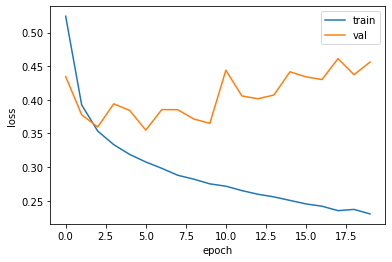

In [9]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

초기에 검증 손실이 발생, 중간에 다시 상승. 훈련 손실은 꾸준히 감소하기 때문에 전형적인 과대적합 모델이 만들어진다. 검증 손실이 상승하는 시점을 가능한 뒤로 늦추면 검증 세트에 대한 손실이 줄어들고, 검증 세트에 대한 정확도도 증가할 것이다.

과대 적합을 막기 위해 3장에서 배운 규제 방식 대신 신경망에 특화된 규제 방법을 다루어보자.
당장은 옵티마이저 하이퍼파리미터를 조정하여 과대적합을 완화시킬 수 있는지 알아보자.

기본 RMSprop 옵티마이저는 많은 문제에서 잘 작동한다. 만약 이 옵티마이저 대신 다른 옵티마이저를 테스트한다면 Adam이 좋은 선택이다. Adam은 적응적 학습률을 사용하기 때문에 에포크가 진행되면서 학습률의 크기를 조정할 수 있다.


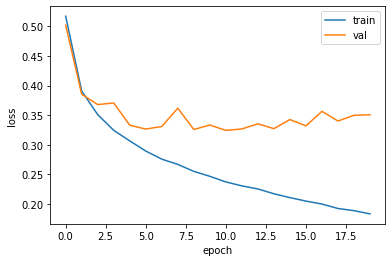

In [10]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history=model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

아까보다는 과대 적합이 줄어들었다. 이는 Adam 옵티마이저가 이 데이터셋에 잘 맞는다는 것을 보여준다. 더 나은 손실 곡선을 얻으려면 학습률을 조정해서 다시 시도해 볼 수도 있다.

## 드롭아웃
이 방식은 훈련 과정에서 층에 있는 일부 뉴런을 랜덤하게 꺼서(출력을 0으로) 과대적합을 막는다.

어떤 샘플을 처리할 때는 은닉층의 두 번째 뉴런이 드롭아웃되어 h2출력이 없다. 다른 샘플을 처리할 때는 은닉층의 첫번째 뉴런이 드롭아웃되어 h1 출력이 없다. 뉴런은 랜덤하게 드롭아웃 되고 얼마나 많은 뉴런을 드롭할지는 우리가 정해야한다.

드롭아웃이 과대적합을 막는 이유는 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄이고, 모든 입력에 대해 주의를 기울여야 한다. 일부 뉴런의 출력이 없을 수 있다는 것을 감안하면 이 신경망은 안정적인 예측을 만들 수 있다.

또 다른 해석은 앞의 드롭아웃이 적용된 2개의 신경망 그림을 보면서 드롭아웃을 적용해 훈련하는 것은 마치 2개의 신경망을 앙상블하는 것처럼 상상할 수 있다. 5장에서 처럼 앙상블은 과대적합을 막는 아주 좋은 기법이다.

케라스에서는 드롭아웃을 keras.layers 패키지 아래 Dropout 클래스로 제공한다. 어떤 층 뒤에 드롭아웃을 두어 이층의 출력을 랜덤하게 0으로 만드는 것이다.

앞서 정의한 model_fn()함수에 드롭아웃 객체를 전달하여 층을 추가해보자.

In [15]:
model=model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               78500     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 10)                1010      
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


드롭아웃 층은 훈련되는 모델 파라미터가 없다. 도한 입력과 출력의 크기가 같다.

물론 훈련이 끝난 뒤에 평가나 예측을 수행할 때는 드롭아웃을 적용하지 말아야 한다. 훈련된 모든 뉴런을 사용해야 올바른 예측을 수행할 수 있기 때문. 텐서플로와 케라스는 모델을 평가와 예측에 사용할 때는 드롭아웃을 자동으로 적용하지 않는다.

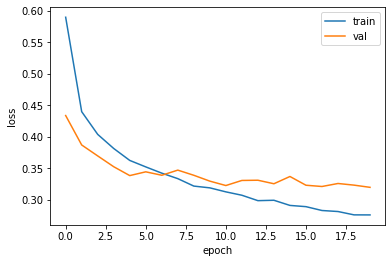

In [12]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history=model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

에포크 중간에 검증 손실에 대한 감소가 멈추지만 크게 상승하지 않고 어느정도 유지되고 있다.

그리고 이 모델은 20번 에포크동안 훈련했기 때문에 과대 적합이 되어있다고 볼 수 있다. 과대 적합이 아닌 모델을 얻기 위해 에포크를 줄일 필요가 있다.

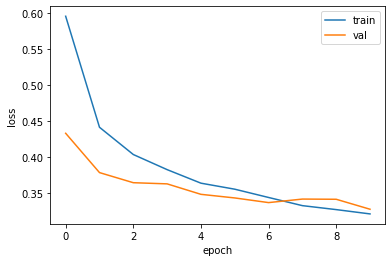

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history=model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

## 모델의 저장과 복원
에포크 횟수를 10으로 지정하고 다시 모델을 훈련했다. 나중에 사용하기 위해 이 모델을 저장해야 한다.

케라스 모델은 훈련된 모델의 파라미터를 저장하는 save_weight() 메서드를 제공한다. 기본적으로 이 메서드는 텐서플로의 체크 포인트 포맷으로 저장하지만 파일의 확장자가 '.h5'인 경우 HDF5 포맷으로 저장한다.

In [19]:
model.save_weights('model-weights.h5')

또 모델 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공한다. 이 메서드는 텐서플로의 SavedModel 포맷으로 저장하지만 파일의 확장자가 '.h5'인 경우 HDF5 포맷으로 저장한다.

In [20]:
model.save('model-whole.h5')

두가지 실험을 해보는데 첫번째는 훈련을 하지 않은 새로운 모델을 만들고 model-weights.h5 파일에서 훈련된 모델 파라미터를 읽어 사용한다.

두번째는 아예 model-whole.h5파일에서 새로운 모델을 만들어 바로 사용한다.

In [21]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

훈련하지 않은 새로운 모델을 만들고 이전에 저장했던 모델 파라미터를 적재했다. 이때 사용하는 메서드는 load_weights() 메서드이다.

### 모델 파라미터 적재 조건
    load_weights() 메서드를 사용하려면 save_weights() 메서드로 저장했던 모델과 정확히 같은 구조를 가져야 한다. 그래서 model_fn() 함수를 사용해 동일한 모델을 만들어 사용했다.

이 모델의 검증 정확도를 확인해보자. 케라스에서 예측을 수행하는 predict() 메서드는 사이킷런과 달리 샘플마다 10개의 클래스에 대한 확률을 반환한다. 패션MNIST 데이터셋이 다중 분류 문제이기 때문이다.

패션 MNIST 데이터셋에서 덜어낸 검증 세트의 샘플 개수는 12000개이기 때문에 predict() 메서드는 (12000, 10) 크기의 배열을 반환한다.

따라서 번거롭지만 10개의 확률 중 가장 큰 값을 골라 타깃 레이블과 비교하여 정확도를 계산하자.

In [22]:
import numpy as np
val_labels = np.argmax(model.predict(val_scaled), axis = -1)
print(np.mean(val_labels == val_target))

0.8800833333333333


모델의 predict() 메서드 결과에서 가장 큰 값을 고르기 위해 넘파이 argmax() 함수를 사용. 이 함수는 배열에서 가장 큰 값의 인덱스를 반환한다.

argmax() 함수의 axis=-1은 배열의 마지막 차원을 따라 최댓값을 고른다. 
argmax()로 고른 인덱스(val_labels)와 타깃(val_target)을 비교한다. 두 배열에서 각 위치의 값이 같으면 1, 다르면 0. 이를 평균으로 하면 정확도가된다.

이번에는 모델 전체를 파일에서 읽은 후 검증 세트의 정확도를 출력해보자.

In [23]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3277 - accuracy: 0.8801


[0.32767918705940247, 0.8800833225250244]

같은 모델을 저장하고 불러들였기 때문에 동일한 정확도를 얻는다.

### 여기는 왜 evaluate() 메서드를 사용하나?
    load_model() 함수는 모델 파라미터, 모델구조, 옵티마이저 상태까지 모두 복원하기 때문에 evaluate() 메서드를 사용할 수 있다.

지금까지의 과정은 20번 에포크 동안 모델 훈련, 검증 점수가 상승하는 지점 확인, 모델을 과대적합 되지 않는 에포크만큼 다시 훈련 과정을 진행했다.

모델을 두번 훈련하지 않고 한번에 끝낼 수 있는 방법을 알아보자.

## 콜백
콜백은 훈련 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로 keras.callbacks 패키지 아래에 있는 클래스들이다. fit() 메서드의 callbacks 매개변수에 리스트로 전달하여 사용한다.

여기서 사용한 ModelCheckpoint 콜백은 기본적으로 최상의 검증 점수를 만드는 모델을 저장한다. 저장될 파일 이름을 'best-model.h5'로 지정하여 콜백 적용해보겠다.



In [24]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5')
model.fit(train_scaled, train_target, epochs=20, verbose=0,
          validation_data = (val_scaled, val_target), callbacks=[checkpoint_cb])

model_fn() 함수로 모델을 만들고 compile() 메서드 호출하는 것은 동일하다. 그 다음 ModelCheckpoint 클래스의 객체 checkpoint_cb 를 만들고 fit() 메서드의 callbacks 매개변수에 리스트로 감싸서 전달한다.

모델이 훈련한 후 best-model.h5에 최상의 검증 점수를 낸 모델이 저장된다. 이 모델을 load_model() 함수로 다시 읽어 예측 수행해보자.

In [25]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3356 - accuracy: 0.8822


[0.335646390914917, 0.8821666836738586]

아까보다 훨씬 나아진 것을 볼 수 있다. ModelCheckpoint 콜백이 가장 낮은 검증 점수의 모델을 자동으로 저장해준다. 하지만 여전히 20번의 에포크 동안 훈련한다. 검증 점수가 상승하기 시작하면 그 이후에는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없다. 이때 훈련을 중지하면 컴퓨터 자원, 시간을 아낄 수 있다. 조기종료를 통해 훈련을 미리 중지할 수 있다.

조기 종료는 훈련 에포크 횟수를 제한하는 역할이지만, 모델 과대적합을 막아주기 때문에 규제 방법 중 하나로 볼 수 있다.

케라스에는 조기 종료를 위한 EarlyStopping 콜백을 제공한다. 이 콜백의 patience 매개변수는 검증 점수가 향상되지 않더라도 참을 에포크 횟수로 지정한다. patience=2로 지정하면 2번 연속 검증 점수가 향상되지 않으면 훈련 중지한다는 의미이다. restore_best_weights 매개변수를 True로 지정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.

EarlyStopping 콜백을 ModelCheckPoint 콜백과 함께 사용하면 가장 낮은 검증 손실의 모델을 파일에 저장하고 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다. 또한 훈련을 중지한 후 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.



In [26]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb=keras.callbacks.ModelCheckpoint('best-model.h5')
early_stopping_cb=keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)
history=model.fit(train_scaled, train_target, epochs=20, verbose=0,
                  validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

EarlyStopping 콜백 추가한것 이외에는 동일하다.
훈련을 마치고 나서 몇번째 에포크에서 훈련이 중지되었는지는 early_stopping_cb 객체의 stopped_epoch 속성에서 확인 가능하다.


In [27]:
print(early_stopping_cb.stopped_epoch)

8


8번째 에포크에서 중지되었다는 의미이므로 최상의 모델은 7번째 에포크 내부일 것이다.

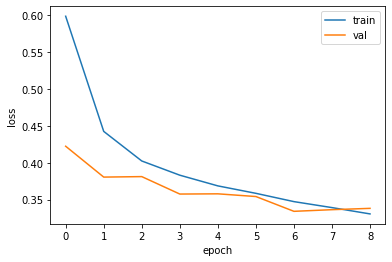

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

조기 종료 기법을 사용하면 안심하고 에포크 횟수를 크게 지정해도 괜찮다. ModelCheckpoint 콜배과 함께 사용하면 최상의 모델을 자동으로 저장해주므로 편리하다.

마지막으로 조기 종료로 얻은 모델을 사용해 검증 세트에 대한 성능을 확인해보자.

In [29]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 1s 1ms/step - loss: 0.3342 - accuracy: 0.8779


[0.3341998755931854, 0.877916693687439]